# POD-DL-ROMs for the resolution of Hemodynamic PDEs

---
## 1 Data Preparation


#### Import useful libraries

In [51]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import os
import vtkmodules.all as vtk
from vtkmodules.util.numpy_support import vtk_to_numpy, numpy_to_vtk
import meshio
from scipy.spatial.distance import cdist
from torchvision import datasets, transforms
import random
from data_handler import *
from ML_handler import *
from plot_handler import *
from models import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#Directory containing data
DATASET_PATH = r'/Users/manuelcurnis/Desktop/EPFL first semester/dataset'

In [3]:
def set_seed(seed):
    """Set the seed for reproducibility

    Args:
        seed: int representing the chosen seed
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

#Fix the seed
set_seed(50)

In [4]:
#Choose the device to use

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Tou are currently using ", device)

Tou are currently using  cpu


#### Import and Preprocess Data

In [5]:
#load paramaters
params, solutions = load_params(DATASET_PATH)

In [6]:
#Convert from numpy to tensor

solutions= torch.tensor(solutions, dtype=torch.float32)
params = torch.tensor(params, dtype=torch.float32)

n_p, rwos_p = params.shape
n_v, rwos_v, cols_v = solutions.shape
print("The shape of the parameters data is", (n_p, rwos_p), "and the shape of the reduced velocities is", (n_v, rwos_v, cols_v))

The shape of the parameters data is (1950, 3) and the shape of the reduced velocities is (1950, 39, 16)


In [7]:
#Split params in train and test with a ratio of 80%/20%
N_data=params.shape[0]
indices = torch.randperm(N_data)
ratio_data=0.8
train_size = int(ratio_data * N_data)
train_indices = indices[:train_size]
test_indices=indices[train_size:]

train_params=params[train_indices]
test_params=params[test_indices]

#Standardize parameters in [0,1]
min_params=torch.min(params,dim=0).values
max_params=torch.max(params,dim=0).values
train_params=(train_params-min_params)/(max_params-min_params)
test_params=(test_params-min_params)/(max_params-min_params)

#Split velocity in train and test
train_vel=solutions[train_indices]
test_vel=solutions[test_indices]

#Standardize parameters in [0,1]
vel_space_max = torch.max(solutions, dim= 0).values
vel_space_min = torch.min(solutions, dim=0).values
train_vel = (train_vel - vel_space_min*0.95) / (1.05*vel_space_max - 0.95*vel_space_min)
test_vel =(test_vel - vel_space_min*0.95) / (1.05*vel_space_max - 0.95*vel_space_min)

---
## 2 Training

In [ ]:
#see SolverPlusMLPAutoencoder in models.py

#### **Hyperparameters optimization**


#### Learning rate


As the parameters to be tuned are many, we start iterating on different learning rates to see the best values.
Since the optimum learning rate and number of epochs for good training should not vary too much with a small change in the architecture, we expect that the good values found for the fixed architecture will also perform well with a slight change in the architecture in the following steps.

We train the model with an arbitrary architecture by varying the learning rate, keeping the number of epochs sufficiently large, to see which learning rate determines the best performance

In [8]:
#Set a standard structure for the model architecture
L_enc_dec=3
dim_reduced = 128
batch_size=32
num_epochs=400

#Values of learning rate
lr_values = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]

final_train_losses_lr = np.zeros((len(lr_values),))
final_val_losses_lr = np.zeros((len(lr_values),))
final_val_rel_losses_lr = np.zeros((len(lr_values),))

train_losses_lr = []
val_losses_lr = []
val_rel_losses_lr = []

for idx, lr in enumerate(lr_values):

        #train the model
        model_trained, train_loss_history, val_loss_history, val_rel_loss_history,  train_loss_enc_dec_history, train_loss_solver_enc_history = run_training_solver_autoencoder(
        SolverPlusMLPAutoencoder(dim_reduced=dim_reduced, activation="gelu", L_enc_dec=L_enc_dec,),
        num_epochs, lr, batch_size, train_params, train_vel, test_params, test_vel, device,  vel_space_max, vel_space_min, weights = [1,1])

        #extract values corresponding to epoch = num_epoch (last values of the lists)
        final_train_losses_lr[idx] = train_loss_history[-1]
        final_val_losses_lr[idx] = val_loss_history[-1]
        final_val_rel_losses_lr[idx] = val_rel_loss_history[-1]

        train_losses_lr.append(train_loss_history)
        val_losses_lr.append(val_loss_history)
        val_rel_losses_lr.append(val_rel_loss_history)

        print("Optimization for lr=",lr, "finished!")


for idx, lr in enumerate(lr_values):
    print(f"LR = {lr}, Train_loss = {final_train_losses_lr[idx]:.4f}, Test_loss = {final_val_losses_lr[idx]:.4f}, test_relative_error = {final_val_rel_losses_lr[idx]:.4f}")

Optimization for lr= 0.0001 finished!
Optimization for lr= 0.0005 finished!
Optimization for lr= 0.001 finished!
Optimization for lr= 0.005 finished!
Optimization for lr= 0.01 finished!
Optimization for lr= 0.05 finished!
LR = 0.0001, Train_loss = 0.0023, Test_loss = 0.0026, test_relative_error = 0.0282
LR = 0.0005, Train_loss = 0.0012, Test_loss = 0.0014, test_relative_error = 0.0249
LR = 0.001, Train_loss = 0.0012, Test_loss = 0.0014, test_relative_error = 0.0246
LR = 0.005, Train_loss = 1.6546, Test_loss = 1.6603, test_relative_error = 0.1707
LR = 0.01, Train_loss = 0.0372, Test_loss = 0.0388, test_relative_error = 0.0252
LR = 0.05, Train_loss = 1.6654, Test_loss = 1.6636, test_relative_error = 0.2703


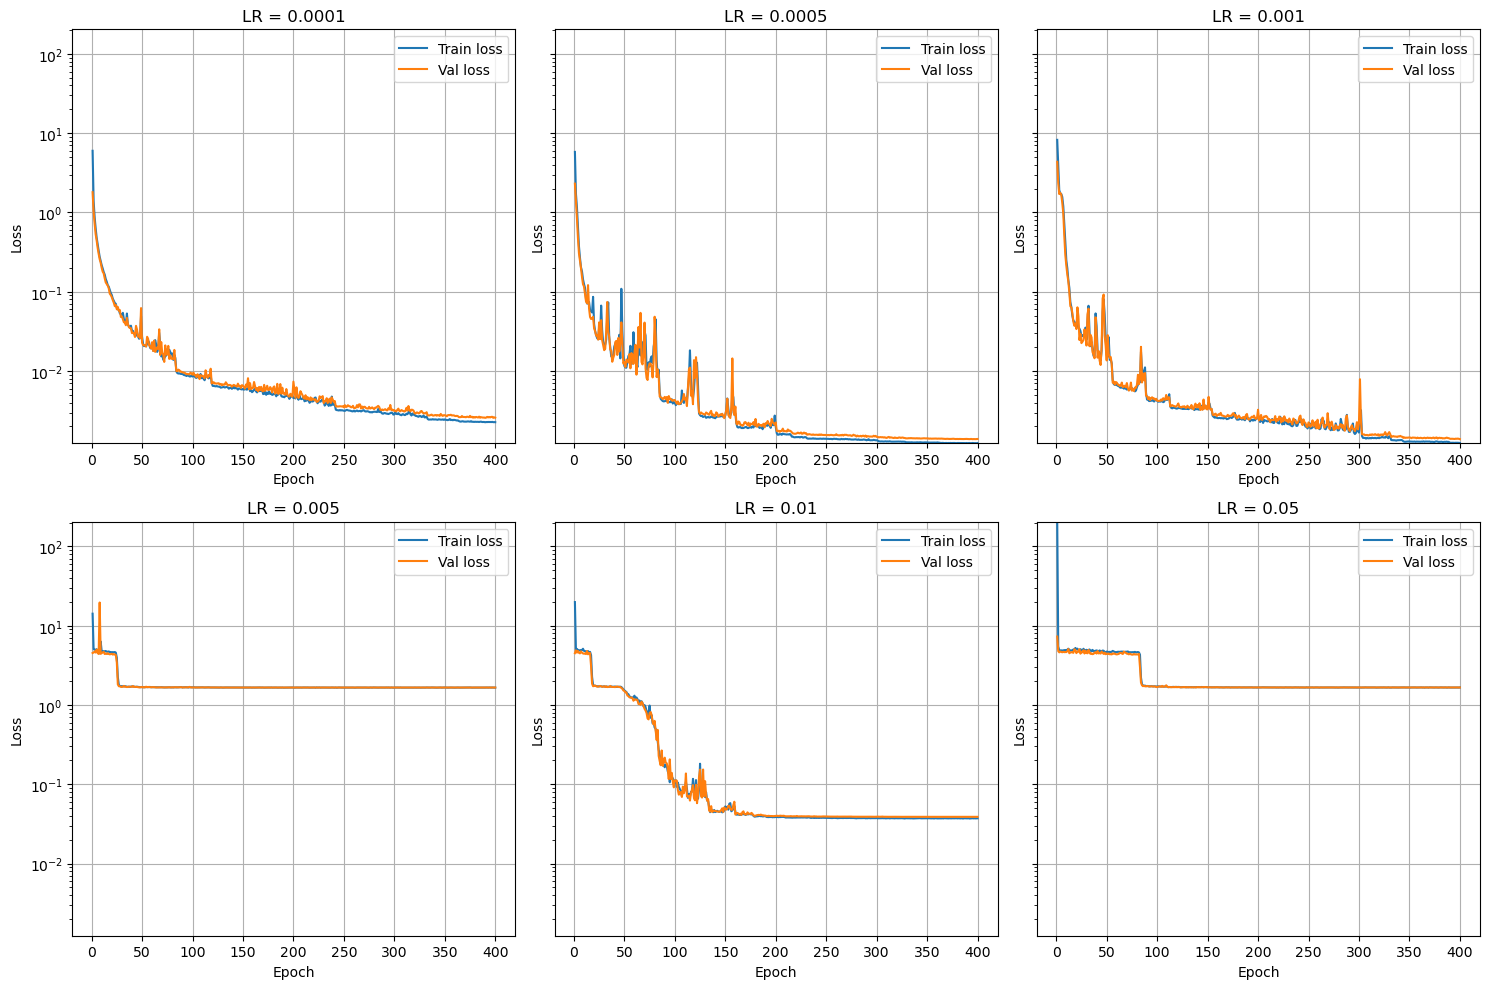

In [9]:
#Plot the graphs changing the learning rate

fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharey=True)

#We fix these values to give a limit to the y-axis of the graphs
y_min = float('inf')
y_max = -float('inf')

################
L_enc_dec=3
dim_reduced = 128
batch_size=32
num_epochs=400 #FORSW 500!!!!
lr_values = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]
################

for idx, lr in enumerate(lr_values):

    row = idx // 3
    col = idx % 3

    plot(ax[row, col], train_losses_lr[idx], val_losses_lr[idx], num_epochs)
    ax[row, col].set_title(f"LR = {lr}")
    y_max = max(y_max, max(np.max(train_losses_lr[idx]), np.max(val_losses_lr[idx]), np.max(val_rel_losses_lr[idx])))
    y_min = min(y_min, min(np.min(train_losses_lr[idx]), np.min(val_losses_lr[idx]), np.min(val_rel_losses_lr[idx])))


for i in range(2):
    for j in range(3):
        ax[i, j].set_ylim(y_min, y_max)


plt.tight_layout()
plt.show()

In [10]:
#Extracting the LR with the highest performance

best_index_lr=np.argmin(final_val_rel_losses_lr)
best_lr = lr_values[best_index_lr]
best_num_epochs=400
print("The best LR is", best_lr,"with", num_epochs, "epochs, with a relative error of", np.min(final_val_rel_losses_lr))

The best LR is 0.001 with 400 epochs, with a relative error of 0.024559772855196244


#### Autoencoder Layers & Latent dimension


In [11]:
l_values = [1, 2, 3, 4]               #number of layers in the encoder (=decoder)
dim_reduced_list = [16, 32, 64, 128, 256] #output dimension of the encoder (latent dimension)


final_train_losses_matrix = np.zeros((len(l_values), len(dim_reduced_list)))
final_val_losses_matrix= np.zeros((len(l_values), len(dim_reduced_list)))
final_rel_losses_matrix = np.zeros((len(l_values), len(dim_reduced_list)))
final_losses_enc_dec_matrix = np.zeros((len(l_values), len(dim_reduced_list)))
final_losses_enc_solver_matrix = np.zeros((len(l_values), len(dim_reduced_list)))

train_losses_L_dimreduced=[]
val_losses_L_dimreduced=[]
rel_losses_L_dimreduced=[]
losses_enc_solver_L_dimreduced=[]
losses_enc_dec_L_dimreduced=[]

for idx_l, l in enumerate(l_values):
   for idx_dim_reduced,  dim_reduced in enumerate(dim_reduced_list):

        model_trained, train_loss_history, val_loss_history, val_rel_loss_history, train_loss_enc_dec_history, train_loss_solver_enc_history = run_training_solver_autoencoder(
        SolverPlusMLPAutoencoder(dim_reduced=dim_reduced, activation="gelu", L_enc_dec=l),
        best_num_epochs, best_lr, batch_size, train_params, train_vel, test_params, test_vel, device, vel_space_max, vel_space_min, weights=[1,1])

        final_train_losses_matrix[idx_l, idx_dim_reduced] = train_loss_history[-1]
        final_val_losses_matrix[idx_l, idx_dim_reduced] = val_loss_history[-1]
        final_rel_losses_matrix[idx_l, idx_dim_reduced] = val_rel_loss_history[-1]
        final_losses_enc_dec_matrix[idx_l, idx_dim_reduced] = train_loss_enc_dec_history[-1]
        final_losses_enc_solver_matrix[idx_l, idx_dim_reduced] = train_loss_solver_enc_history[-1]


        train_losses_L_dimreduced.append(train_loss_history)
        val_losses_L_dimreduced.append(val_loss_history)
        rel_losses_L_dimreduced.append(val_rel_loss_history)
        losses_enc_dec_L_dimreduced.append(train_loss_enc_dec_history)
        losses_enc_solver_L_dimreduced.append(train_loss_solver_enc_history)
        
        print("Optimization for L=",l,"and latent dimension=", dim_reduced, "finished!")

for idx_l, l in enumerate(l_values):
   for idx_dim_reduced,  dim_reduced in enumerate(dim_reduced_list):
       print(f"Layers = {l}, dim_reduced = {dim_reduced}, Train_loss = {final_train_losses_matrix[idx_l,idx_dim_reduced ]:.4f}, Test_loss = {final_val_losses_matrix[idx_l,idx_dim_reduced ]:.4f}, test_relative_error = {final_rel_losses_matrix[idx_l,idx_dim_reduced ]:.4f}")

Optimization for L= 1 and latent dimension= 16 finished!
Optimization for L= 1 and latent dimension= 32 finished!
Optimization for L= 1 and latent dimension= 64 finished!
Optimization for L= 1 and latent dimension= 128 finished!
Optimization for L= 1 and latent dimension= 256 finished!
Optimization for L= 2 and latent dimension= 16 finished!
Optimization for L= 2 and latent dimension= 32 finished!
Optimization for L= 2 and latent dimension= 64 finished!
Optimization for L= 2 and latent dimension= 128 finished!
Optimization for L= 2 and latent dimension= 256 finished!
Optimization for L= 3 and latent dimension= 16 finished!
Optimization for L= 3 and latent dimension= 32 finished!
Optimization for L= 3 and latent dimension= 64 finished!
Optimization for L= 3 and latent dimension= 128 finished!
Optimization for L= 3 and latent dimension= 256 finished!
Optimization for L= 4 and latent dimension= 16 finished!
Optimization for L= 4 and latent dimension= 32 finished!
Optimization for L= 4 and

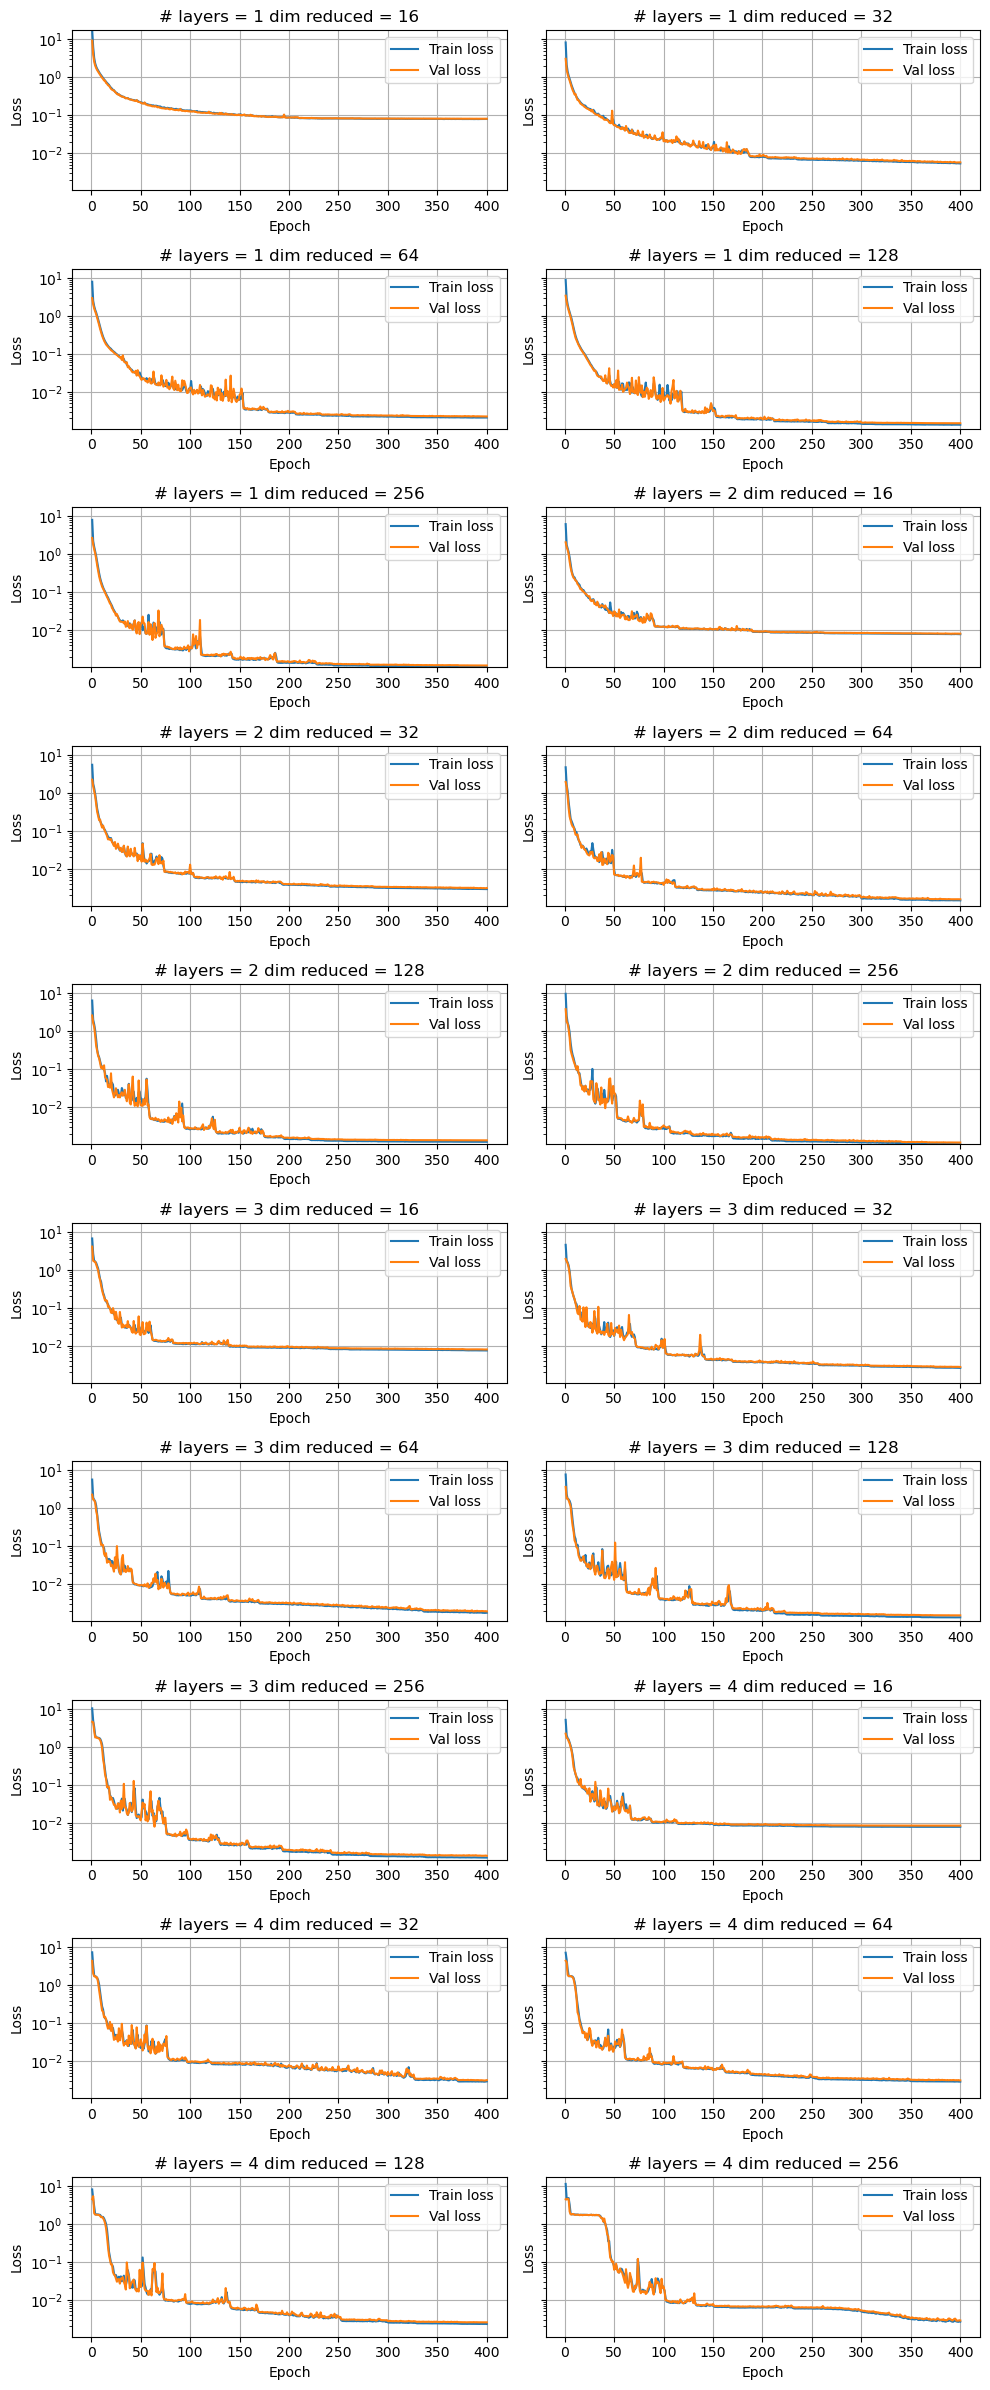

In [12]:
#Plot the graphs

fig, ax = plt.subplots(10, 2, figsize=(10, 24), sharey=True)
y_min = float('inf')
y_max = -float('inf')

for idx_l, l in enumerate(l_values):
   for idx_dim_reduced,  dim_reduced in enumerate(dim_reduced_list):
        
        subplot_index = idx_l * len(dim_reduced_list) + idx_dim_reduced
        row = subplot_index // 2
        col = subplot_index % 2

        plot(ax[row, col], train_losses_L_dimreduced[subplot_index], val_losses_L_dimreduced[subplot_index],  best_num_epochs)
        ax[row, col].set_title(f"# layers = {l} dim reduced = {dim_reduced}", )
        y_max = max(y_max, max(np.max(train_losses_L_dimreduced[subplot_index]), np.max(val_losses_L_dimreduced[subplot_index]), np.max(rel_losses_L_dimreduced[subplot_index])))
        y_min = min(y_min, min(np.min(train_losses_L_dimreduced[subplot_index]), np.min(val_losses_L_dimreduced[subplot_index]), np.min(rel_losses_L_dimreduced[subplot_index])))


for i in range(10):
    for j in range(2):
        ax[i, j].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()


### choose the best model based on his relative error and the compleity (number of paramaters of the model)

In [35]:
total_paramaters_matrix=np.zeros((len(l_values), len(dim_reduced_list)))

for idx_l in range(len(l_values)):
    for idx_dim in range(len(dim_reduced_list)):
        model_ = SolverPlusMLPAutoencoder(dim_reduced=dim_reduced_list[idx_dim], activation="gelu", L_enc_dec=l_values[idx_l])
        total_params = sum(p.numel() for p in model_.parameters())
        total_paramaters_matrix[idx_l, idx_dim] = total_params

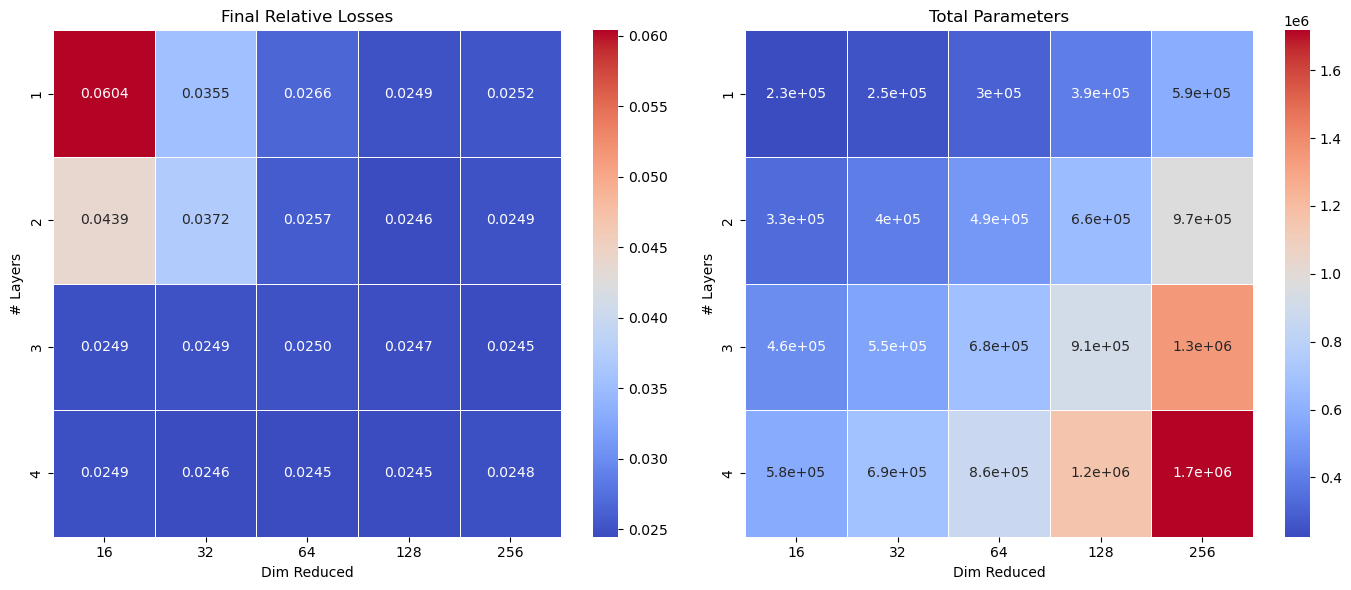

In [38]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 riga, 2 colonne

# Prima heatmap
sns.heatmap(final_rel_losses_matrix, annot=True, cmap='coolwarm', fmt=".4f", linewidths=0.5, 
            yticklabels=['1', '2', '3', '4'], xticklabels=['16', '32', '64', '128', '256'], ax=axes[0])
axes[0].set_title("Final Relative Losses")
axes[0].set_xlabel("Dim Reduced")
axes[0].set_ylabel("# Layers")

# Seconda heatmap
sns.heatmap(total_paramaters_matrix, annot=True, cmap='coolwarm', linewidths=0.5, 
            yticklabels=['1', '2', '3', '4'], xticklabels=['16', '32', '64', '128', '256'], ax=axes[1])
axes[1].set_title("Total Parameters")
axes[1].set_xlabel("Dim Reduced")
axes[1].set_ylabel("# Layers")

# Mostra il grafico
plt.tight_layout()
plt.show()

In [13]:
#Extracting the best model changing layers in the autoencoder and latent dimension
best_index=np.argmin(final_rel_losses_matrix)

best_row = best_index // 5
best_col = best_index % 5

best_L_enc_dec= l_values[best_row]
best_dim_reduced = dim_reduced_list[best_col]
print(f"best_L_enc_dec = {best_L_enc_dec}, best_dim_reduced = {best_dim_reduced}, with a relative error of", np.min(final_rel_losses_matrix))

best_L_enc_dec = 3, best_dim_reduced = 256, with a relative error of 0.024475359248045163


#### Observe the trend of the two components of the loss for the best model

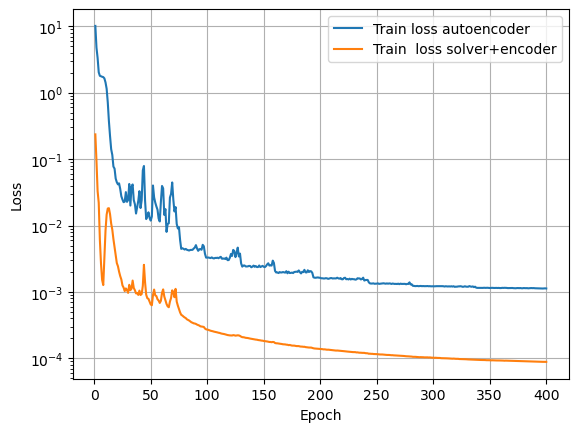

In [14]:
t = np.arange(1, num_epochs + 1)

plt.semilogy(t, losses_enc_dec_L_dimreduced[best_index], label="Train loss autoencoder")
plt.semilogy(t, losses_enc_solver_L_dimreduced[best_index], label="Train  loss solver+encoder")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True) 

The difference in magnitude between the two losses leads to analyze how their contribute to the global loss should be weighted.
Therefore we perform some optimizations varying their weights in the sum, given the number of epochs, the learning rate, the number of layers in the autoencoder and the latent dimension

#### Weight $w$  ($\mathcal{L}_{autoenc}+w\mathcal{L}_{enc,solv}$)

In [15]:
w_values=[1/100,1/10,1/5,5,10,100]

final_train_losses_w = np.zeros((len(w_values),))
final_val_losses_w= np.zeros((len(w_values),))
final_val_rel_losses_w = np.zeros((len(w_values),))

train_losses_w = []
val_losses_w = []
val_rel_losses_w = []

for idx_w, w_value in enumerate(w_values):

      model_trained, train_loss_history, val_loss_history, val_rel_loss_history, train_loss_enc_dec_history, train_loss_solver_enc_history = run_training_solver_autoencoder(
      SolverPlusMLPAutoencoder(dim_reduced=best_dim_reduced, activation="gelu", L_enc_dec=best_L_enc_dec,),
      best_num_epochs, best_lr, batch_size, train_params, train_vel, test_params, test_vel, device,  vel_space_max, vel_space_min, weights=[1,w_value])

      final_train_losses_w[idx_w] = train_loss_history[-1]
      final_val_losses_w[idx_w] = val_loss_history[-1]
      final_val_rel_losses_w[idx_w] = val_rel_loss_history[-1]

      train_losses_w.append(train_loss_history)
      val_losses_w.append(val_loss_history)
      val_rel_losses_w.append(val_rel_loss_history)

      print("Optimization for w=",w_value, "finished!")


for idx_w, w_value in enumerate(w_values):
    print(f"Weight value = {w_value}, Train_loss = {final_train_losses_w[idx_w]:.4f}, Test_loss = {final_val_losses_w[idx_w]:.4f}, test_relative_error = {final_val_rel_losses_w[idx_w]:.4f}")

Optimization for w= 0.01 finished!
Optimization for w= 0.1 finished!
Optimization for w= 0.2 finished!
Optimization for w= 5 finished!
Optimization for w= 10 finished!
Optimization for w= 100 finished!
Weight value = 0.01, Train_loss = 0.0011, Test_loss = 0.0013, test_relative_error = 0.0268
Weight value = 0.1, Train_loss = 0.0011, Test_loss = 0.0013, test_relative_error = 0.0249
Weight value = 0.2, Train_loss = 0.0012, Test_loss = 0.0014, test_relative_error = 0.0245
Weight value = 5, Train_loss = 0.0013, Test_loss = 0.0015, test_relative_error = 0.0244
Weight value = 10, Train_loss = 0.0019, Test_loss = 0.0020, test_relative_error = 0.0254
Weight value = 100, Train_loss = 0.0030, Test_loss = 0.0031, test_relative_error = 0.0247


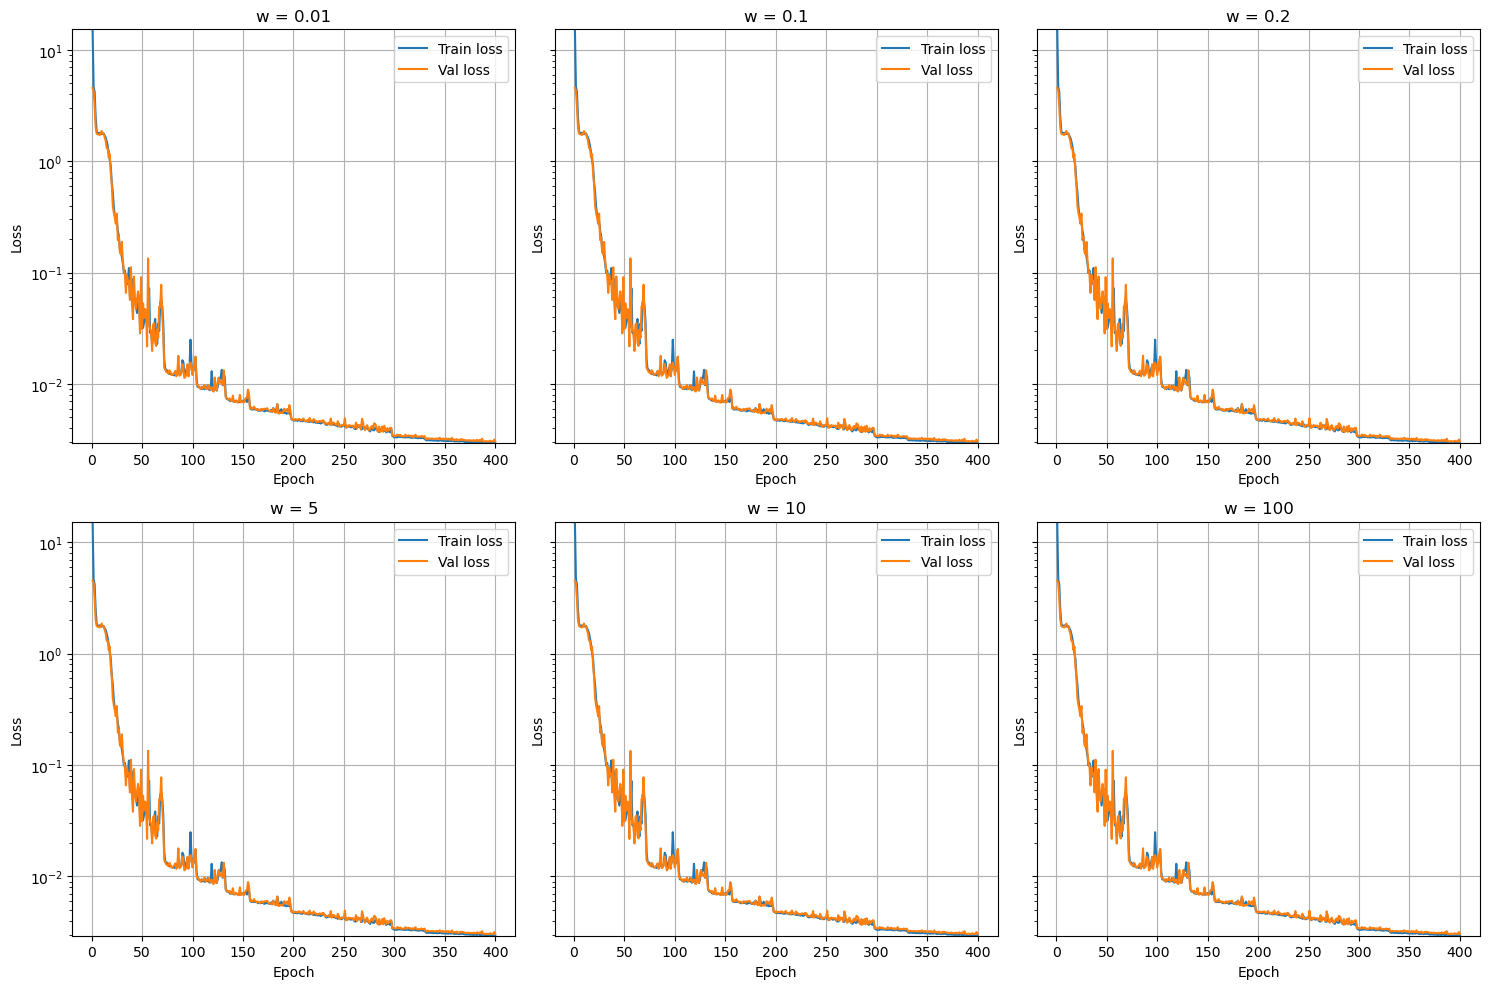

In [39]:
#Plot the graphs changing w

fig, ax = plt.subplots(2, 3 , figsize=(15, 10), sharey=True)
y_min = float('inf')
y_max = -float('inf')

for idx_w, w_value in enumerate(w_values):
      row = idx_w // 3
      col = idx_w % 3

      #plot the graphs
      plot(ax[row,col], train_losses_w[idx], val_losses_w[idx], best_num_epochs)
      ax[row, col].set_title(f"w = {w_value}")
      y_max = max(y_max, max(np.max(train_losses_w[idx]), np.max(val_losses_w[idx]), np.max(val_rel_losses_w[idx])))
      y_min = min(y_min, min(np.min(train_losses_w[idx]), np.min(val_losses_w[idx]), np.min(val_rel_losses_w[idx])))

for i in range(2):
  for j in range(3):
      ax[i, j].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

In [40]:
#Extracting the best model changing w
best_index=np.argmin(final_val_rel_losses_w)

best_w=w_values[best_index]
print(f"best w = {best_w}, with a relative error of", np.min(final_val_rel_losses_w))
print("Anyway it is still higher than with w=1")

best w = 5, with a relative error of 0.024424339792667293
Anyway it is still higher than with w=1


#### **Sequential Training**

We investigate how the performance changes applying a sequential training. First, the autoencoder is trained. Then, the solver is trained to reproduce the output of the encoder.

The hyperparameters used in this section are the best hyperparamaters found above

#### Training Autoencoder

In [41]:
#Training

num_epochs=500 #very slow

autoencoder_trained, train_loss_history_autoenc, val_loss_history_autoenc = run_training(
        Autoencoder(dim_reduced=best_dim_reduced, activation="gelu", L_enc_dec=best_L_enc_dec), 
        num_epochs, best_lr, batch_size,  train_params, train_vel, test_params, test_vel, vel_space_max, vel_space_min, device)

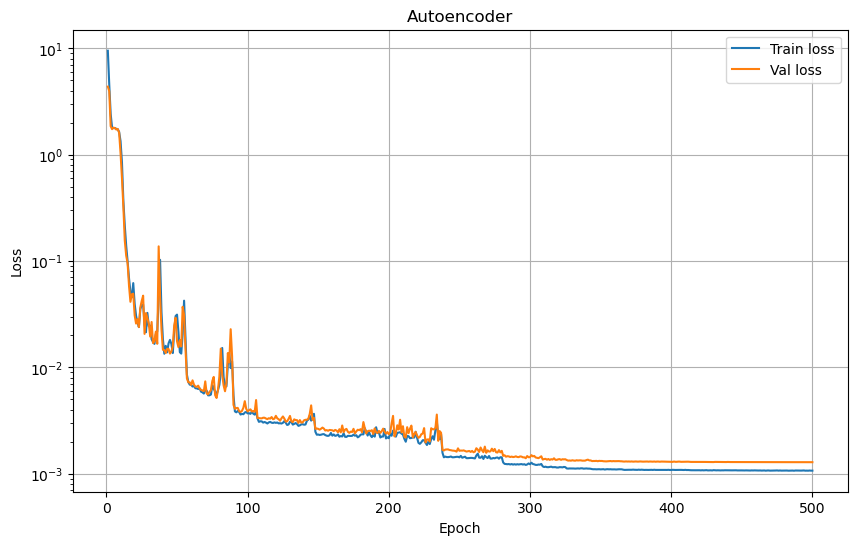

The loss obtained after the optimization is: 0.001283765505426205


In [42]:
#Plotting results for the Autoencoder
fig, ax = plt.subplots(figsize=(10, 6))
plot(ax, train_loss_history_autoenc, val_loss_history_autoenc, num_epochs)
ax.set_title(f"Autoencoder")
ax.grid(True)
#plt.tight_layout()
plt.show()

print("The loss obtained after the optimization is:", val_loss_history_autoenc[-1])

In [43]:
#training Solver

num_epochs=400 #?????????

solver_trained, train_loss_history_solver, val_loss_history_solver = run_training_solver(
        autoencoder_trained,
        Solver(dim_reduced=best_dim_reduced),
        num_epochs, 0.001, batch_size, train_params, train_vel, test_params, test_vel, device)

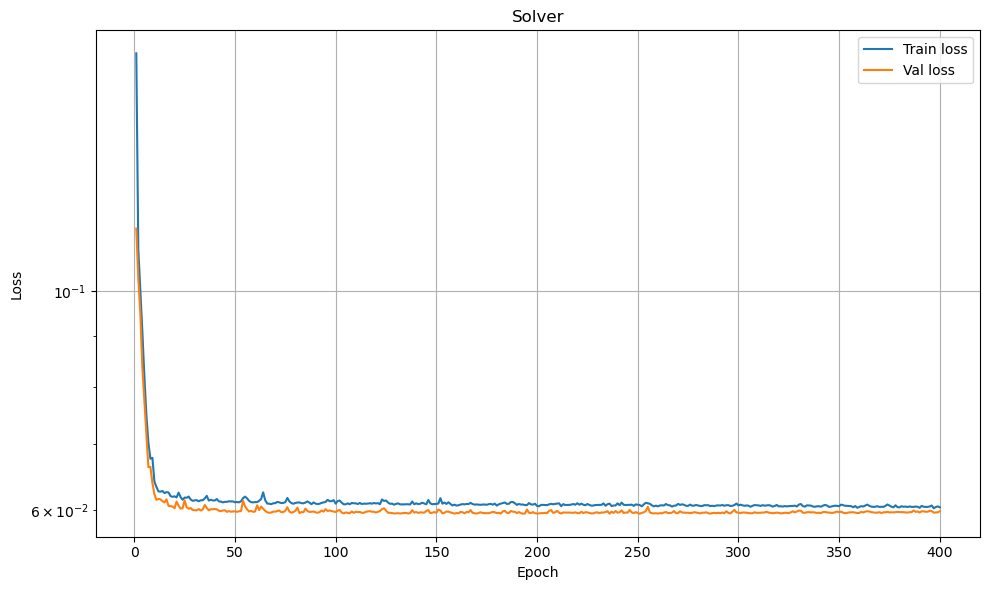

The loss obtained after the optimization is: 0.059800828916904254


In [44]:
#Plotting results for the solver

fig, ax = plt.subplots(figsize=(10, 6))
plot(ax, train_loss_history_solver, val_loss_history_solver, num_epochs)
ax.set_title(f"Solver")
ax.grid(True)
plt.tight_layout()
plt.show()

print("The loss obtained after the optimization is:", val_loss_history_solver[-1])

In [45]:
#Performance Evaluation of Sequential Training

solver_trained.eval()
autoencoder_trained.eval()

err_rel=0
with torch.no_grad():
  for (param, vel) in zip(test_params, test_vel):

    param=param.unsqueeze(dim=0)
    param=param.to(device)

    vel=vel.to(device)

    vel_reduced_predict=solver_trained(param)
    vel_predict=autoencoder_trained.decoder(vel_reduced_predict)

    vel_predict=vel_predict.squeeze(dim=0)

    vel_predict=vel_predict*(1.05*vel_space_max.to(device) - 0.95*vel_space_min.to(device))+0.95*vel_space_min.to(device)
    vel=vel*(1.05*vel_space_max.to(device) - 0.95*vel_space_min.to(device))+0.95*vel_space_min.to(device)

    err_rel+=torch.norm(vel_predict-vel)/torch.norm(vel)

  err_rel=err_rel.item()/len(test_params)
  print("The validation test relative error for the sequential training is: ", err_rel)


The validation test relative error for the sequential training is:  0.060126270392002204


#### **Convolutional Autoencoder**

In [ ]:
# see SolverPlusConvAutoencoder in models.py 

In [46]:
activation="gelu"
pooling="avg"
K_comb=[5,1,2]
lr=0.001
num_epochs=400 #FORSE RIFARE CON 500????
dim_reduced=128

Lc_Ll_list=[(2,2),(2,3),(3,2)]  #each element is a tuple (#convolutional layers, # dense layers)

final_train_losses_conv = np.zeros((len(Lc_Ll_list),))
final_val_losses_conv= np.zeros((len(Lc_Ll_list),))
final_val_rel_losses_conv = np.zeros((len(Lc_Ll_list),))

train_losses_conv = []
val_losses_conv = []
val_rel_losses_conv = []

for idx_conv, el in enumerate(Lc_Ll_list):
    L_c=el[0]
    L_l=el[1]
    model_trained, train_loss_history,  val_loss_history, val_rel_loss_history, train_loss_enc_dec_history, train_loss_solver_enc_history = run_training_solver_autoencoder(
        SolverPlusConvAutoencoder(activation, pooling, K_comb, L_c, L_l,  dim_reduced=dim_reduced), num_epochs, lr, batch_size, train_params, train_vel, test_params, test_vel,  device, vel_space_max, vel_space_min)

    final_train_losses_conv[idx_conv] = train_loss_history[-1]
    final_val_losses_conv[idx_conv] = val_loss_history[-1]
    final_val_rel_losses_conv[idx_conv] = val_rel_loss_history[-1]

    train_losses_conv.append(train_loss_history)
    val_losses_conv.append(val_loss_history)
    val_rel_losses_conv.append(val_rel_loss_history)

    print("Optimization for (L_c, L_l)=", el, "finished!")

for idx_conv, el in enumerate(Lc_Ll_list):
    print(f"(L_c, L_l) = {el}, Train_loss = {final_train_losses_conv[idx_conv]:.4f}, Test_loss = {final_val_losses_conv[idx_conv]:.4f}, test_relative_error = {final_val_rel_losses_conv[idx_conv]:.4f}")

Optimization for (L_c, L_l)= (2, 2) finished!
Optimization for (L_c, L_l)= (2, 3) finished!
Optimization for (L_c, L_l)= (3, 2) finished!
(L_c, L_l) = (2, 2), Train_loss = 0.0070, Test_loss = 0.0074, test_relative_error = 0.0264
(L_c, L_l) = (2, 3), Train_loss = 0.0073, Test_loss = 0.0081, test_relative_error = 0.0261
(L_c, L_l) = (3, 2), Train_loss = 0.0094, Test_loss = 0.0103, test_relative_error = 0.0263


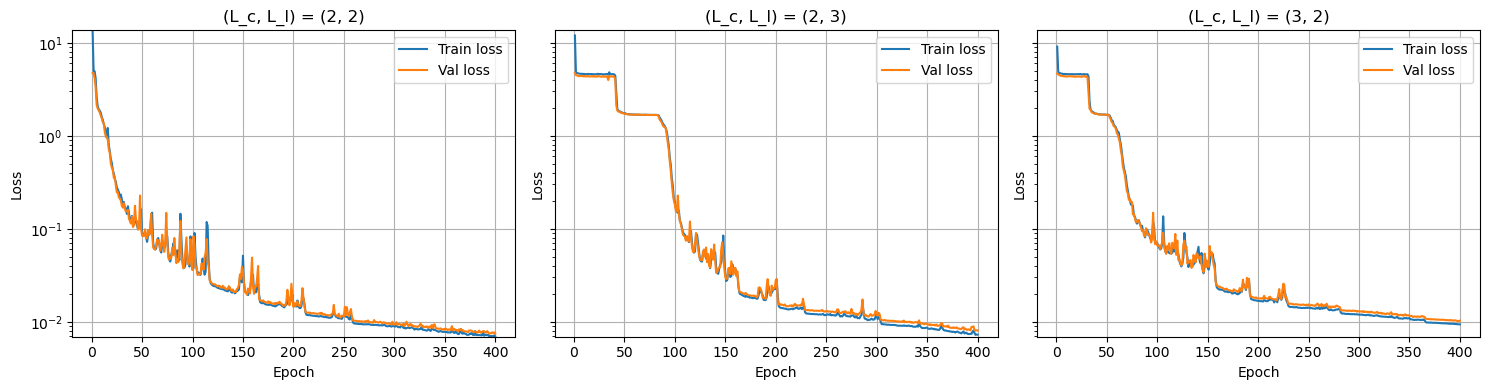

In [47]:
#Plot the graphs using a convolutional autoencoder

fig, ax = plt.subplots(1, 3 , figsize=(15, 4), sharey=True)
y_min = float('inf')
y_max = -float('inf')

for idx_conv, el in enumerate(Lc_Ll_list):
      
      plot(ax[idx_conv], train_losses_conv[idx_conv], val_losses_conv[idx_conv], num_epochs)
      ax[idx_conv].set_title(f"(L_c, L_l) = {el}")
      y_max = max(y_max, max(np.max(train_losses_conv[idx_conv]), np.max(val_losses_conv[idx_conv]), np.max(val_rel_losses_conv[idx_conv])))
      y_min = min(y_min, min(np.min(train_losses_conv[idx_conv]), np.min(val_losses_conv[idx_conv]), np.min(val_rel_losses_conv[idx_conv])))

for i in range(3):
      ax[i].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

#### **Cross-validation over the best model**

In [52]:
def build_k_indices(N, k_fold):
    """build k indices for k-fold.

    Args:
        y:      shape=(N,)
        k_fold: K in K-fold, i.e. the fold num

    Returns:
        A 2D array of shape=(k_fold, N/k_fold) that indicates the data indices for each fold
    """
    interval = int(N / k_fold) #number of data per fold-set
    indices = np.random.permutation(N) #permutation of array from 0 to num_row
    k_indices = [indices[k * interval : (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)



k_fold = 5
k_indices=build_k_indices(len(params), k_fold)

train_loss_crossval=[]
val_loss_crossval=[]
val_rel_loss_crossval=[]

for k in range (0, k_fold):
    test_vel_k=solutions[k_indices[k,:]]
    train_params_k=params[np.delete(k_indices, k, axis=0).ravel()]
    train_vel_k=solutions[np.delete(k_indices, k, axis=0).ravel()]
    test_params_k=params[k_indices[k]]

    test_vel_k=(test_vel_k - vel_space_min.to('cpu')*0.95) / (1.05*vel_space_max.to('cpu') - 0.95*vel_space_min.to('cpu'))
    train_vel_k=(train_vel_k - vel_space_min.to('cpu')*0.95) / (1.05*vel_space_max.to('cpu') - 0.95*vel_space_min.to('cpu'))
    train_params_k=(train_params_k-min_params)/(max_params-min_params)
    test_params_k=(test_params_k-min_params)/(max_params-min_params)

    model_trained, train_loss_history, val_loss_history, val_rel_loss_history, train_loss_enc_dec_history, train_loss_solver_enc_history = run_training_solver_autoencoder(
        SolverPlusMLPAutoencoder(activation="gelu", L_enc_dec=best_L_enc_dec, dim_reduced=best_dim_reduced),
        best_num_epochs, best_lr, batch_size, train_params_k, train_vel_k, test_params_k, test_vel_k, device, vel_space_max, vel_space_min, weights=[1,1])

    train_loss_crossval.append(train_loss_history[-1])
    val_loss_crossval.append(val_loss_history[-1])
    val_rel_loss_crossval.append(val_rel_loss_history[-1])
    print("Optimization for optimization", k+1, "over", k_fold, "finished! Relative error:", val_rel_loss_history[-1])

Optimization for optimization 1 over 5 finished! Relative error: 0.025255941427670993
Optimization for optimization 2 over 5 finished! Relative error: 0.024693849912056556
Optimization for optimization 3 over 5 finished! Relative error: 0.024228113316572628
Optimization for optimization 4 over 5 finished! Relative error: 0.024986795431528337
Optimization for optimization 5 over 5 finished! Relative error: 0.024655066163111954


In [53]:
#Computing the mean over the k_fold

mean_train_loss=sum(train_loss_crossval)/k_fold
mean_val_loss=sum(val_loss_crossval)/k_fold
mean_val_rel_loss=sum(val_rel_loss_crossval)/k_fold

print("The mean training loss is: ", mean_train_loss)
print("The mean test loss is: ", mean_val_loss)
print("The mean validation relative error is: ", mean_val_rel_loss)

#Final best model
best_model=model_trained

The mean training loss is:  0.0011070449999048529
The mean test loss is:  0.0013256050505412696
The mean validation relative error is:  0.02476395325018809


In [54]:
best_model.eval()

chosen_index=np.random.randint(0, len(test_params))
input_tensor = test_params[chosen_index,:]
input_tensor = input_tensor.unsqueeze(dim=0)
input_tensor = input_tensor.to(device)

with torch.no_grad():
    predicted_vel = model_trained.predict(input_tensor)
predicted_vel=predicted_vel[0]
predicted_vel=predicted_vel.to("cpu")
predicted_vel=predicted_vel*(1.05*vel_space_max.to("cpu") - 0.95*vel_space_min.to("cpu"))+0.95*vel_space_min.to("cpu")

true_vel=test_vel[chosen_index]*(1.05*vel_space_max.to("cpu") - 0.95*vel_space_min.to("cpu"))+0.95*vel_space_min.to("cpu")
rel_err_reduced=(torch.norm((predicted_vel-true_vel).view(-1)/torch.norm(true_vel.view(-1,)))).item()
print("The relative error between the ground truth and the prediction is:", rel_err_reduced*100,"%")

H1_space_norm_predict = np.linalg.norm(predicted_vel.numpy() @ basis_time["velocity"].T, axis=0)
H1_space_norm_true = np.linalg.norm(true_vel.numpy() @ basis_time["velocity"].T, axis=0)
H1_space_norm_diff = np.linalg.norm((true_vel-predicted_vel).numpy() @ basis_time["velocity"].T, axis=0)

fig, axs = plt.subplots(1, 2, figsize=(15, 4))

axs[0].plot(np.arange(len(H1_space_norm_true)),H1_space_norm_true,label="ground truth", linewidth=2)
axs[0].plot(np.arange(len(H1_space_norm_predict)),H1_space_norm_predict,label="prediction", linestyle='--')
axs[0].legend()
axs[0].set_xlabel("Time step")
axs[0].set_ylabel(r'$||u||_{H^1}(t)$')
axs[0].set_title(r'$H^1$ norm of the velocity')
axs[0].grid(True)

axs[1].plot(np.arange(len(H1_space_norm_true)),H1_space_norm_diff/H1_space_norm_true, linewidth=2)
axs[1].set_xlabel("Time step")
axs[1].set_ylabel(r'$\frac{||u_{pred}-u_{true}||_{H^1}}{||u_{true}||}(t)$')
axs[1].set_title(r'Relative error in $H^1$ norm')
axs[1].grid(True)

plt.show()

#Export data to visualize the field in 3D (e.g. ParaView)
visualize_solution(predicted_vel.numpy() ,fields={'velocity': 3}, step_t=5)

The relative error between the ground truth and the prediction is: 1.713084988296032 %


NameError: name 'basis_time' is not defined